# Data Driven Dealings Development


*   EDA on Sales Data
*   Feature Engineering and Clustering
*   Predicting Sales
*   Market Basket
*   Recommending Items per Customer







In [1]:
# To be able to use your data stored in your Google Drive you first need to mount your Google Drive so you can load and save files to it. 
from google.colab import drive
drive.mount('/content/gdrive')
#You'll need to put in a token which Google will generate for you as soon as you click on the link

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
data = pd.read_excel('/content/gdrive/My Drive/DDDDFolder/DDDD.xlsx')
data.head()

,SalesDate,SalesValue,SalesAmount,Customer,SalesTransactionID,SalesItem
0,2018-09-28,8280.0,10,0,0,0
1,2018-09-28,7452.0,10,0,0,0
2,2019-04-23,21114.0,30,0,1,0
3,2019-04-23,7038.0,10,0,1,1
4,2019-04-23,7000.0,2,0,1,2


In [3]:
data['SalesDate'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  341422
unique                   1008
top       2018-02-20 00:00:00
freq                      927
first     2016-05-02 00:00:00
last      2020-01-31 00:00:00
Name: SalesDate, dtype: object

In [4]:
data['Customer'].nunique()

35

In [5]:
CustUnique = pd.DataFrame(data['Customer'].unique())
CustUnique.columns = ['Customer']
CustUnique.count()

Customer    35
dtype: int64

## Recency

In [6]:
data['SalesDate'] = pd.to_datetime(data['SalesDate'])

In [7]:
MaxPurchaseDate = data.groupby('Customer').SalesDate.max().reset_index()
MaxPurchaseDate.columns = ['Customer','MaxPurchaseDate']
MaxPurchaseDate.head()

,Customer,MaxPurchaseDate
0,0,2019-12-23
1,1,2020-01-21
2,2,2020-01-29
3,3,2020-01-10
4,4,2020-01-29


In [8]:
#take the overall max date and calculate the difference in days for each customer`s max date from that overall max date
MaxPurchaseDate['Recency'] = (MaxPurchaseDate['MaxPurchaseDate'].max() - MaxPurchaseDate['MaxPurchaseDate']).dt.days
CustUnique = pd.merge(CustUnique, MaxPurchaseDate[['Customer','Recency']], on='Customer')
CustUnique.head()

,Customer,Recency
0,0,39
1,1,10
2,3,21
3,4,2
4,5,28


In [9]:
CustUnique.Recency.describe()

count      35.000000
mean      132.000000
std       287.880592
min         0.000000
25%         1.500000
50%        16.000000
75%        52.000000
max      1032.000000
Name: Recency, dtype: float64

In [10]:
import plotly.offline as pyoff
import plotly.graph_objs as go
plot_data = [
    go.Histogram(
        x=CustUnique['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

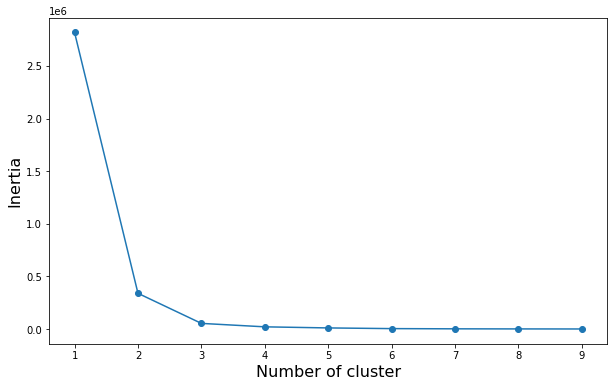

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertia={}
RecencyInertia = CustUnique[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(RecencyInertia)
    RecencyInertia["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.xticks(list(inertia.keys()))
plt.show();

In [12]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(CustUnique[['Recency']])
CustUnique['RecencyCluster'] = kmeans.predict(CustUnique[['Recency']])

In [13]:
CustUnique.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,30.0,23.366667,38.534788,0.0,1.0,10.0,25.0,168.0
1,3.0,979.000000,72.794231,896.0,952.5,1009.0,1020.5,1032.0
2,2.0,491.000000,8.485281,485.0,488.0,491.0,494.0,497.0


In [14]:
def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(data,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [15]:
CustUnique = order_cluster('RecencyCluster', 'Recency',CustUnique,False)

In [16]:
CustUnique.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,3.0,979.000000,72.794231,896.0,952.5,1009.0,1020.5,1032.0
1,2.0,491.000000,8.485281,485.0,488.0,491.0,494.0,497.0
2,30.0,23.366667,38.534788,0.0,1.0,10.0,25.0,168.0


## Frequency

In [17]:
Frequency = data.groupby('Customer').SalesDate.count().reset_index()

In [18]:
Frequency.columns = ['Customer','Frequency']

In [19]:
Frequency.head()

,Customer,Frequency
0,0,46
1,1,176
2,2,7662
3,3,86
4,4,4164


In [20]:
CustUnique = pd.merge(CustUnique, Frequency, on='Customer')

In [21]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency
0,0,39,2,46
1,1,10,2,176
2,3,21,2,86
3,4,2,2,4164
4,5,28,2,437


In [22]:
CustUnique.Frequency.describe()

count        35.000000
mean       9754.914286
std       27539.816995
min           1.000000
25%          42.500000
50%         176.000000
75%        5773.000000
max      150043.000000
Name: Frequency, dtype: float64

In [23]:
plot_data = [
    go.Histogram(
        x=CustUnique.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

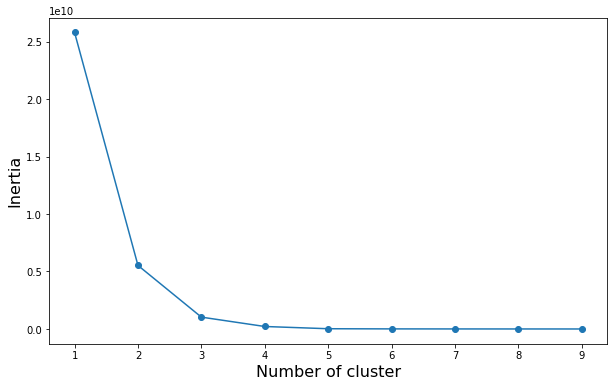

In [24]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertia={}
Frequency = CustUnique[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Frequency)
    Frequency["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.xticks(list(inertia.keys()))
plt.show()

In [25]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(CustUnique[['Frequency']])
CustUnique['FrequencyCluster'] = kmeans.predict(CustUnique[['Frequency']])

In [26]:
CustUnique.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3.0,28884.666667,1639.314593,27276.0,28050.5,28825.0,29689.00,30553.0
1,30.0,1429.733333,2701.605907,1.0,36.0,138.0,463.25,8771.0
2,1.0,150043.000000,NaN,150043.0,150043.0,150043.0,150043.00,150043.0
3,1.0,61833.000000,NaN,61833.0,61833.0,61833.0,61833.00,61833.0


In [27]:
CustUnique = order_cluster('FrequencyCluster', 'Frequency',CustUnique,True)
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster
0,0,39,2,46,0
1,1,10,2,176,0
2,3,21,2,86,0
3,4,2,2,4164,0
4,5,28,2,437,0


## Monetary Value

In [28]:
# renaming Sales Value into Net Sales as a clearer column name
data['NetSales'] = data['SalesValue'] 

In [29]:
NetSales = data.groupby('Customer').NetSales.sum().reset_index()

In [30]:
NetSales.head()

,Customer,NetSales
0,0,365063.03
1,1,524331.16
2,2,7974948.61
3,3,71220.01
4,4,6286328.77


In [31]:
NetSales.sort_values(by='NetSales', ascending=False)

,Customer,NetSales
30,31,3.895101e+08
29,30,3.433869e+08
8,8,8.903569e+07
24,25,7.936539e+07
20,20,1.944865e+07
21,21,1.608147e+07
12,12,1.427919e+07
33,34,1.137023e+07
28,29,1.120207e+07
2,2,7.974949e+06


In [32]:
CustUnique = pd.merge(CustUnique, NetSales, on='Customer')

In [33]:
CustUnique.NetSales.describe()

count    3.500000e+01
mean     2.896995e+07
std      8.673526e+07
min      3.304000e+02
25%      1.033341e+05
50%      1.161396e+06
75%      9.588511e+06
max      3.895101e+08
Name: NetSales, dtype: float64

In [34]:
plot_data = [
    go.Histogram(
        x=CustUnique['NetSales']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

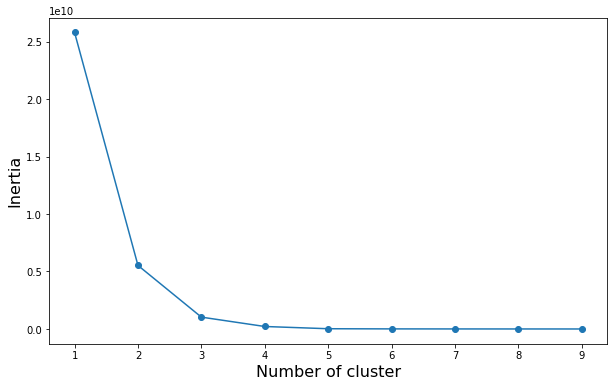

In [35]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertia={}
RevenueInertia = CustUnique[['NetSales']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Frequency)
    RevenueInertia["clusters"] = kmeans.labels_
    inertia[k] = kmeans.inertia_ 

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.xlabel("Number of cluster", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.xticks(list(inertia.keys()))
plt.show();



In [36]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(CustUnique[['NetSales']])
CustUnique['NetSalesCluster'] = kmeans.predict(CustUnique[['NetSales']])

In [37]:
CustUnique = order_cluster('NetSalesCluster', 'NetSales',CustUnique,True)

In [38]:
CustUnique.groupby('NetSalesCluster')['NetSales'].describe()

,count,mean,std,min,25%,50%,75%,max
NetSalesCluster,,,,,,,,
0,31.0,3.633879e+06,5.440494e+06,3.304000e+02,7.990305e+04,5.243312e+05,5.031393e+06,1.944865e+07
1,2.0,8.420054e+07,6.837932e+06,7.936539e+07,8.178297e+07,8.420054e+07,8.661811e+07,8.903569e+07
2,1.0,3.433869e+08,NaN,3.433869e+08,3.433869e+08,3.433869e+08,3.433869e+08,3.433869e+08
3,1.0,3.895101e+08,NaN,3.895101e+08,3.895101e+08,3.895101e+08,3.895101e+08,3.895101e+08


Bringing it all together

In [39]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster
0,0,39,2,46,0,365063.03,0
1,1,10,2,176,0,524331.16,0
2,3,21,2,86,0,71220.01,0
3,4,2,2,4164,0,6286328.77,0
4,5,28,2,437,0,395756.34,0


In [40]:
CustUnique['OverallScore'] = CustUnique['RecencyCluster'] + CustUnique['FrequencyCluster']  + CustUnique['NetSalesCluster']

In [41]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore
0,0,39,2,46,0,365063.03,0,2
1,1,10,2,176,0,524331.16,0,2
2,3,21,2,86,0,71220.01,0,2
3,4,2,2,4164,0,6286328.77,0,2
4,5,28,2,437,0,395756.34,0,2


In [42]:
CustUnique.groupby('OverallScore').Customer.count()/CustUnique.Customer.count()

OverallScore
0    0.085714
1    0.057143
2    0.714286
3    0.028571
4    0.057143
7    0.057143
Name: Customer, dtype: float64

In [43]:
CustUnique.groupby('OverallScore')['Recency','Frequency','NetSales'].mean()

,Recency,Frequency,NetSales
OverallScore,,,
0,979.00,2935.666667,3.811347e+06
1,491.00,65.500000,1.267742e+06
2,27.96,1358.160000,3.169283e+06
3,0.00,27276.000000,1.944865e+07
4,1.00,29689.000000,8.420054e+07
7,0.00,105938.000000,3.664485e+08


In [44]:
CustUnique.groupby('OverallScore')['Recency'].count()

OverallScore
0     3
1     2
2    25
3     1
4     2
7     2
Name: Recency, dtype: int64

In [45]:
CustUnique['Segment'] = 'High'
CustUnique.loc[CustUnique['OverallScore']<5,'Segment'] = 'Mid' 
CustUnique.loc[CustUnique['OverallScore']<4,'Segment'] = 'Low'

In [46]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment
0,0,39,2,46,0,365063.03,0,2,Low
1,1,10,2,176,0,524331.16,0,2,Low
2,3,21,2,86,0,71220.01,0,2,Low
3,4,2,2,4164,0,6286328.77,0,2,Low
4,5,28,2,437,0,395756.34,0,2,Low


In [47]:
CustUnique.groupby('Segment').Customer.count()/CustUnique.Customer.count()


Segment
High    0.057143
Low     0.885714
Mid     0.057143
Name: Customer, dtype: float64

In [48]:
#import plotly_express as px
import plotly.express as px
fig = px.scatter_3d(CustUnique, x='Recency', y='Frequency', z='NetSales',
              color='Segment')
fig.show()

In [49]:
# Recency vs Frequency
GraphTwoDim = CustUnique

plot_data = [
    go.Scatter(
        x=GraphTwoDim.query("Segment == 'Low'")['Frequency'],
        y=GraphTwoDim.query("Segment == 'Low'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'Mid'")['Frequency'],
        y=GraphTwoDim.query("Segment == 'Mid'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'High'")['Frequency'],
        y=GraphTwoDim.query("Segment == 'High'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Recency"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [50]:
# Recency vs NetSales
GraphTwoDim = CustUnique

plot_data = [
    go.Scatter(
        x=GraphTwoDim.query("Segment == 'Low'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'Low'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'Mid'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'Mid'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'High'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'High'")['Recency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Recency"},
        xaxis= {'title': "NetSales"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [51]:
# Frequency vs NetSales
GraphTwoDim = CustUnique

plot_data = [
    go.Scatter(
        x=GraphTwoDim.query("Segment == 'Low'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'Low'")['Frequency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'Mid'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'Mid'")['Frequency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode mid
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'High'")['NetSales'],
        y=GraphTwoDim.query("Segment == 'High'")['Frequency'],
        text=GraphTwoDim['Customer'], # tooltip for customercode high
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "NetSales"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [52]:
# Frequency vs Recency
GraphTwoDim = CustUnique

plot_data = [
    go.Scatter(
        x=GraphTwoDim.query("Segment == 'Low'")['Recency'],
        y=GraphTwoDim.query("Segment == 'Low'")['Frequency'],
        mode='markers',
        text=GraphTwoDim['Customer'], # tooltip for customercode low
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'Mid'")['Recency'],
        y=GraphTwoDim.query("Segment == 'Mid'")['Frequency'],
        mode='markers',
        text=GraphTwoDim['Customer'], # tooltip for customercode mid
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=GraphTwoDim.query("Segment == 'High'")['Recency'],
        y=GraphTwoDim.query("Segment == 'High'")['Frequency'],
        mode='markers',
        text=GraphTwoDim['Customer'], # tooltip for customercode high
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [53]:
GraphTwoDim.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment
0,0,39,2,46,0,365063.03,0,2,Low
1,1,10,2,176,0,524331.16,0,2,Low
2,3,21,2,86,0,71220.01,0,2,Low
3,4,2,2,4164,0,6286328.77,0,2,Low
4,5,28,2,437,0,395756.34,0,2,Low


In [54]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment
0,0,39,2,46,0,365063.03,0,2,Low
1,1,10,2,176,0,524331.16,0,2,Low
2,3,21,2,86,0,71220.01,0,2,Low
3,4,2,2,4164,0,6286328.77,0,2,Low
4,5,28,2,437,0,395756.34,0,2,Low


## PCA: Dimension Reduction on four features

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X =  CustUnique[['RecencyCluster','FrequencyCluster','NetSalesCluster']]
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-0.261465,-0.275183
1,-0.261465,-0.275183
2,-0.261465,-0.275183
3,-0.261465,-0.275183
4,-0.261465,-0.275183


In [56]:
MergedPcaDf = pd.concat([principalDf, CustUnique[['Segment']]], axis = 1) #OverallScore or Segment
MergedPcaDf.head()

,principal component 1,principal component 2,Segment
0,-0.261465,-0.275183,Low
1,-0.261465,-0.275183,Low
2,-0.261465,-0.275183,Low
3,-0.261465,-0.275183,Low
4,-0.261465,-0.275183,Low


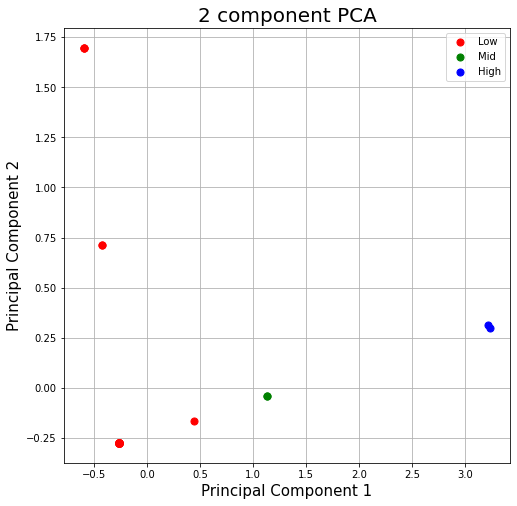

In [57]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low','Mid','High']#targets = ['Low','Mid','High']#targets = ['1','2','3','4','5','8']
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = MergedPcaDf['Segment'] == target
    ax.scatter(MergedPcaDf.loc[indicesToKeep, 'principal component 1']
               , MergedPcaDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [58]:
pca.explained_variance_ratio_

array([0.66831231, 0.2946169 ])

The explained variance tells you how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. By using the attribute explained_variance_ratio_, you can see that the first principal component contains 66% of the variance and the second principal component contains 29% of the variance. Together, the two components contain 95% of the information.One of the most important applications of PCA is for speeding up machine learning algorithms. 

In [59]:
# checking the accuracy on our logistic regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define dataset
X, y =  CustUnique[['RecencyCluster','FrequencyCluster','NetSalesCluster','NetSales','Recency','Frequency']],CustUnique.OverallScore
# define the pipeline
steps = [('pca', PCA(n_components=2)), ('m', LogisticRegression())]# reducing 3 features to 2
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.722 (0.208)


In [60]:
# now making predictions with our PCA model
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define dataset
X, y =  CustUnique[['RecencyCluster','FrequencyCluster','NetSalesCluster']],CustUnique.OverallScore # OverallScore vs Segment
# define the model
steps = [('pca', PCA(n_components=2)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
#A new row of data with 3 columns is provided and is automatically transformed to 2 components and fed to the logistic regression model in order to predict the class label.
row = [[2,1,1]]
yhat = model.predict(row)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


## Feature Engineering

In [61]:
# After successfully reducing features with PCA, we will now feature engineer even more to see if this improves our prediction
from datetime import datetime, timedelta,date
Past6M = data[(data.SalesDate < datetime (2018,9,1)) & (data.SalesDate >= datetime (2018,3,1))].reset_index(drop=True)
FirstPurchInMostCurrent3M = data[(data.SalesDate >= datetime(2018,9,1)) & (data.SalesDate < datetime(2018,12,1))].reset_index(drop=True)


In [62]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment
0,0,39,2,46,0,365063.03,0,2,Low
1,1,10,2,176,0,524331.16,0,2,Low
2,3,21,2,86,0,71220.01,0,2,Low
3,4,2,2,4164,0,6286328.77,0,2,Low
4,5,28,2,437,0,395756.34,0,2,Low


In [63]:

NextSales = data[(data.SalesDate >= datetime(2018,9,1)) & (data.SalesDate < datetime(2018,12,1))].reset_index(drop=True)

#now adding more features
#create a dataframe with customer and first purchase date in NextSales
NextSales_first_purchase = NextSales.groupby('Customer').SalesDate.min().reset_index()
NextSales_first_purchase.columns = ['Customer','MinPurchaseDate']

#create a dataframe with customer and last purchase date in FirstPurchInMostCurrent3M
LastSales = FirstPurchInMostCurrent3M.groupby('Customer').SalesDate.max().reset_index()
LastSales.columns = ['Customer','MaxPurchaseDate']

#merge two dataframes
NextLastSales = pd.merge(LastSales,NextSales_first_purchase,on='Customer',how='left')

#calculate the time difference in days:
NextLastSales['NextPurchaseDay'] = (NextLastSales['MaxPurchaseDate'] - NextLastSales['MinPurchaseDate']).dt.days

#merge with CustUnique 
CustUnique = pd.merge(CustUnique, NextLastSales[['Customer','NextPurchaseDay']],on='Customer',how='left')



In [64]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment,NextPurchaseDay
0,0,39,2,46,0,365063.03,0,2,Low,61.0
1,1,10,2,176,0,524331.16,0,2,Low,46.0
2,3,21,2,86,0,71220.01,0,2,Low,33.0
3,4,2,2,4164,0,6286328.77,0,2,Low,84.0
4,5,28,2,437,0,395756.34,0,2,Low,52.0


In [65]:
#create a dataframe with Customer and Purchase Date
FirstPurchInMostCurrent3MOrderedDaily = FirstPurchInMostCurrent3M[['Customer','SalesDate']]
#convert Invoice Datetime to day
FirstPurchInMostCurrent3MOrderedDaily['SalesDate'] = FirstPurchInMostCurrent3M['SalesDate'].dt.date
FirstPurchInMostCurrent3MOrderedDaily = FirstPurchInMostCurrent3MOrderedDaily.sort_values(['Customer','SalesDate'])
#drop duplicates
FirstPurchInMostCurrent3MOrderedDaily = FirstPurchInMostCurrent3MOrderedDaily.drop_duplicates(subset=['Customer','SalesDate'],keep='first')

In [66]:
#shifting last 3 purchase dates
FirstPurchInMostCurrent3MOrderedDaily['PrevInvoiceDate'] = FirstPurchInMostCurrent3MOrderedDaily.groupby('Customer')['SalesDate'].shift(1)
FirstPurchInMostCurrent3MOrderedDaily['T2InvoiceDate'] = FirstPurchInMostCurrent3MOrderedDaily.groupby('Customer')['SalesDate'].shift(2)
FirstPurchInMostCurrent3MOrderedDaily['T3InvoiceDate'] = FirstPurchInMostCurrent3MOrderedDaily.groupby('Customer')['SalesDate'].shift(3)

In [67]:
FirstPurchInMostCurrent3MOrderedDaily.head()

,Customer,SalesDate,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
3,0,2018-09-21,NaN,NaN,NaN
0,0,2018-09-28,2018-09-21,NaN,NaN
932,0,2018-10-30,2018-09-28,2018-09-21,NaN
2,0,2018-11-21,2018-10-30,2018-09-28,2018-09-21
1038,1,2018-10-11,NaN,NaN,NaN


In [68]:
FirstPurchInMostCurrent3MOrderedDaily['DayDiff'] = (FirstPurchInMostCurrent3MOrderedDaily['SalesDate'] - FirstPurchInMostCurrent3MOrderedDaily['PrevInvoiceDate']).dt.days
FirstPurchInMostCurrent3MOrderedDaily['DayDiff2'] = (FirstPurchInMostCurrent3MOrderedDaily['SalesDate'] - FirstPurchInMostCurrent3MOrderedDaily['T2InvoiceDate']).dt.days
FirstPurchInMostCurrent3MOrderedDaily['DayDiff3'] = (FirstPurchInMostCurrent3MOrderedDaily['SalesDate'] - FirstPurchInMostCurrent3MOrderedDaily['T3InvoiceDate']).dt.days

In [69]:
FirstPurchInMostCurrent3MOrderedDaily.head()

,Customer,SalesDate,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
3,0,2018-09-21,NaN,NaN,NaN,NaN,NaN,NaN
0,0,2018-09-28,2018-09-21,NaN,NaN,7.0,NaN,NaN
932,0,2018-10-30,2018-09-28,2018-09-21,NaN,32.0,39.0,NaN
2,0,2018-11-21,2018-10-30,2018-09-28,2018-09-21,22.0,54.0,61.0
1038,1,2018-10-11,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
FirstPurchInMostCurrent3MOrderedDailyDayDiff = FirstPurchInMostCurrent3MOrderedDaily.groupby('Customer').agg({'DayDiff': ['mean','std']}).reset_index()
FirstPurchInMostCurrent3MOrderedDailyDayDiff.columns = ['Customer', 'DayDiffMean','DayDiffStd']

In [71]:
FirstPurchInMostCurrent3MOrderedDaily_last = FirstPurchInMostCurrent3MOrderedDaily.drop_duplicates(subset=['Customer'],keep='last')

In [72]:
FirstPurchInMostCurrent3MOrderedDaily_last = FirstPurchInMostCurrent3MOrderedDaily_last.dropna()
FirstPurchInMostCurrent3MOrderedDaily_last = pd.merge(FirstPurchInMostCurrent3MOrderedDaily_last, FirstPurchInMostCurrent3MOrderedDailyDayDiff, on='Customer')
CustUnique = pd.merge(CustUnique, FirstPurchInMostCurrent3MOrderedDaily_last[['Customer','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='Customer')

NextPurchaseClass = CustUnique.copy()
NextPurchaseClass = pd.get_dummies(NextPurchaseClass)

In [73]:
CustUnique.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,Segment,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,0,39,2,46,0,365063.03,0,2,Low,61.0,22.0,54.0,61.0,20.333333,12.583057
1,4,2,2,4164,0,6286328.77,0,2,Low,84.0,7.0,14.0,21.0,7.636364,4.653444
2,5,28,2,437,0,395756.34,0,2,Low,52.0,14.0,38.0,52.0,17.333333,5.773503
3,7,0,2,4637,0,7112198.63,0,2,Low,84.0,7.0,14.0,21.0,7.000000,0.000000
4,12,3,2,7027,0,14279188.28,0,2,Low,84.0,7.0,11.0,14.0,7.000000,2.593699


In [74]:
NextPurchaseClass['NextPurchaseDayRange'] = 8
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<88,'NextPurchaseDayRange'] = 7
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<86,'NextPurchaseDayRange'] = 6
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<84,'NextPurchaseDayRange'] = 5
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<82,'NextPurchaseDayRange'] = 4
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<80,'NextPurchaseDayRange'] = 3
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<78,'NextPurchaseDayRange'] = 2
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<76,'NextPurchaseDayRange'] = 1
NextPurchaseClass.loc[NextPurchaseClass.NextPurchaseDay<74,'NextPurchaseDayRange'] = 0


In [75]:
NextPurchaseClass.groupby('NextPurchaseDayRange').Customer.count()/NextPurchaseClass.Customer.count()

NextPurchaseDayRange
0    0.294118
2    0.058824
6    0.352941
7    0.235294
8    0.058824
Name: Customer, dtype: float64

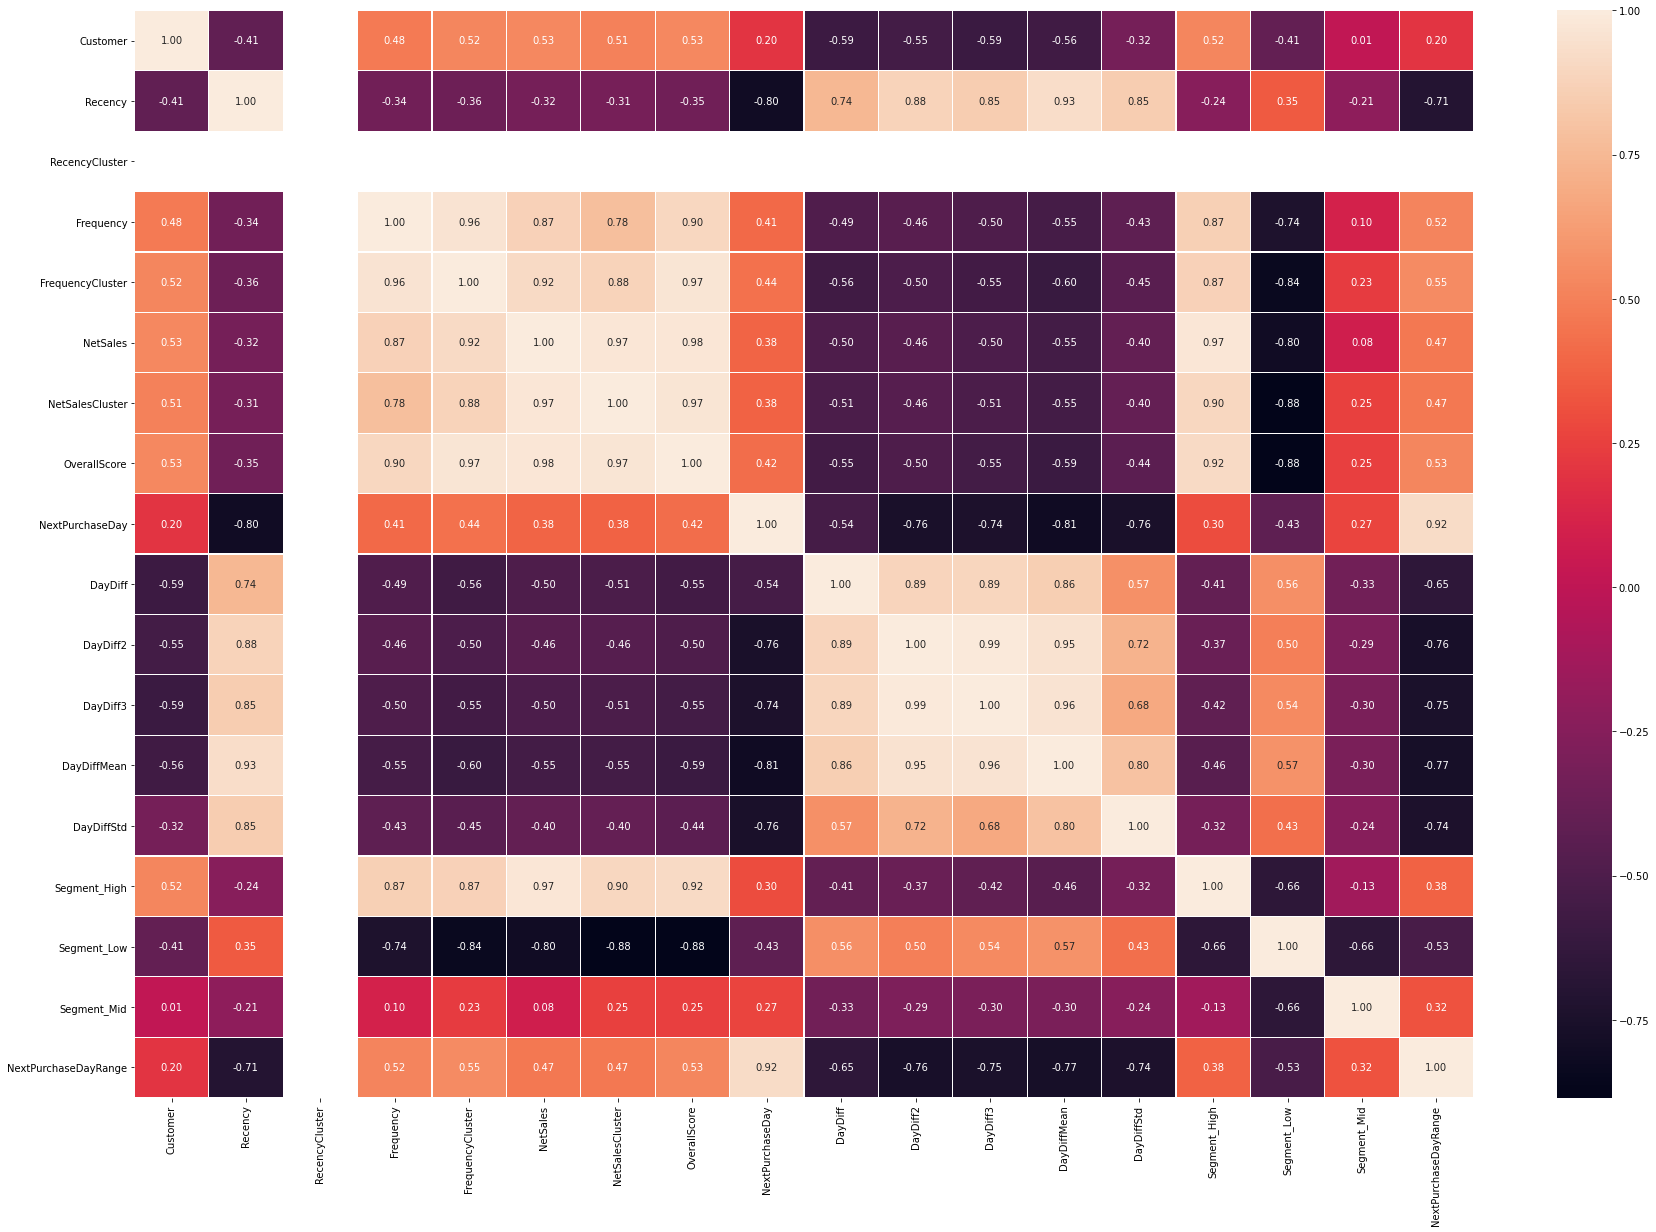

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = NextPurchaseClass[NextPurchaseClass.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [77]:
corr_matrix=NextPurchaseClass.corr()
corr_matrix['NextPurchaseDayRange'].sort_values(ascending=False)

NextPurchaseDayRange    1.000000
NextPurchaseDay         0.923261
FrequencyCluster        0.550071
OverallScore            0.525936
Frequency               0.520825
NetSalesCluster         0.469354
NetSales                0.467209
Segment_High            0.377079
Segment_Mid             0.317169
Customer                0.202176
Segment_Low            -0.527319
DayDiff                -0.650556
Recency                -0.707652
DayDiffStd             -0.742435
DayDiff3               -0.746830
DayDiff2               -0.759833
DayDiffMean            -0.767868
RecencyCluster               NaN
Name: NextPurchaseDayRange, dtype: float64

In [78]:
NextPurchaseClass.head()

,Customer,Recency,RecencyCluster,Frequency,FrequencyCluster,NetSales,NetSalesCluster,OverallScore,NextPurchaseDay,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High,Segment_Low,Segment_Mid,NextPurchaseDayRange
0,0,39,2,46,0,365063.03,0,2,61.0,22.0,54.0,61.0,20.333333,12.583057,0,1,0,0
1,4,2,2,4164,0,6286328.77,0,2,84.0,7.0,14.0,21.0,7.636364,4.653444,0,1,0,6
2,5,28,2,437,0,395756.34,0,2,52.0,14.0,38.0,52.0,17.333333,5.773503,0,1,0,0
3,7,0,2,4637,0,7112198.63,0,2,84.0,7.0,14.0,21.0,7.000000,0.000000,0,1,0,6
4,12,3,2,7027,0,14279188.28,0,2,84.0,7.0,11.0,14.0,7.000000,2.593699,0,1,0,6


In [79]:
test=NextPurchaseClass.NextPurchaseDayRange.unique()
print (test)

[0 6 2 7 8]


In [80]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X, y = NextPurchaseClass.drop('NextPurchaseDayRange',axis=1), NextPurchaseClass.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [81]:
NextPurchaseClass.NextPurchaseDayRange.head()

0    0
1    6
2    0
3    6
4    6
Name: NextPurchaseDayRange, dtype: int64

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
#models.append(("XGB",xgb.XGBClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.14285714 0.        ]
NB [0.42857143 0.66666667]
RF [0.42857143 0.66666667]
SVC [0.28571429 0.33333333]
Dtree [0.42857143 0.5       ]


In [83]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.75


In [84]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.39285714285714285)

In [85]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5,min_child_weihgt=1, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.75


In [86]:
NextPurchaseClass.groupby('NextPurchaseDayRange').Customer.count()/NextPurchaseClass.Customer.count()

NextPurchaseDayRange
0    0.294118
2    0.058824
6    0.352941
7    0.235294
8    0.058824
Name: Customer, dtype: float64

In [87]:
y_pred = ltv_xgb_model.predict(X_test)

In [88]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4

